# А/В-тестирование

Наша задача — провести оценку результатов А/В-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Необходимо:
- оценить корректность проведения теста;
- проанализировать результаты теста.

**Техническое задание**

- название теста: `recommender_system_test`;
- группы: А — контрольная, В — новая платежная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000;
- ожидаемый эффект: *за 14 дней с момента регистрации* пользователи покажут улучшение каждой метрики не менее, чем на 10%:
1. конверсии в просмотр карточек товаров — событие `product_page`;
2. просмотры корзины — `product_cart`;
3. покупки — `purchase`.

## Изучение данных из файла и предобработка данных

Любое аналитическое исследование начинается с обзора данных. Тем более, что заранее о качестве предоставляемых данных ничего не известно. 

Начнем нашу работу с импорта ряда библиотек-основных инструментов аналитика.

In [1]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import plotly.express as px
import datetime as dt
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st

Читаем предоставленные нам файлы и сохраняем в соответствующие переменные. При загрузке датасетов столбцы с датой имеют тип данных `object`. Переведем столбцы с датами к нужным типам на этапе загрузки датафрейма, указав параметр `parse_dates`:

In [2]:
try:
    ab_project_marketing_events = pd.read_csv(
        '/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt']
    )
    final_ab_new_users = pd.read_csv(
        '/datasets/final_ab_new_users.csv', parse_dates=['first_date']
    )
    final_ab_events = pd.read_csv(
        '/datasets/final_ab_events.csv', parse_dates=['event_dt']
    )
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    ab_project_marketing_events = pd.read_csv(
        'ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt']
    )
    final_ab_new_users = pd.read_csv(
        'final_ab_new_users.csv', parse_dates=['first_date']
    )
    final_ab_events = pd.read_csv(
        'final_ab_events.csv', parse_dates=['event_dt']
    )
    final_ab_participants = pd.read_csv('final_ab_participants.csv')

### Датасет `ab_project_marketing_events`

Этот датасет — это календарь маркетинговых событий на 2020 год. Выведем его полностью на экран:

In [3]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Обратимся к документации к данным:

* `name` —  название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` —  дата начала кампании;
* `finish_dt` — дата завершения кампании.

Получим общую информацию о таблице:

In [4]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


Поскольку таблица небольшого размера, то в данном случае легко самостоятельно заметить, что в ней отсутствуют пропуски и дубликаты. Также стоит отметить, что все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

### Датасет `final_ab_new_users`

Этот датасет содержит информацию о всех пользователях, которые зарегистрировались в интернет-магазине в период с 7 по 21 декабря 2020 года. Выведем первые 5 строк на экран:

In [5]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Обратимся к документации к данным:

* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.


Получим общую информацию о таблице:

In [6]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


Мы видим, что в таблице отсутствуют пропуски, а все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

Проведем проверку на наличие скрытых дубликатов; выведем на экран уникальные значения из столбцов `region` и `device`:

In [7]:
print(final_ab_new_users['region'].unique())
print(final_ab_new_users['device'].unique())

['EU' 'N.America' 'APAC' 'CIS']
['PC' 'Android' 'iPhone' 'Mac']


Все корректно. Проведем проверку на наличие полных дубликатов:

In [8]:
final_ab_new_users.duplicated().sum()

0

В этом датасете отсутствуют дубликаты.

### Датасет `final_ab_events`

Этот датасет содержит информацию о всех событиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. Выведем первые 5 строк на экран:

In [9]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Обратимся к документации к данным:

* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события;
* `details` —  дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.


Получим общую информацию о таблице:

In [10]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


Мы видим, что в этом датасете в столбце `details` присутствуют пропуски:

In [11]:
final_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Если исходить из документации к данным, то мы можем предположить, что пропуски в этом столбце связаны с особенностями сбора данных: не все события располагают какими-либо дополнительными данными. Мы с точностью можем быть уверены только в том, что дополнительные данные указываются в случае покупки. Изучим этот вопрос подробнее. Для начала выведем на экран все возможные варианты событий:

In [12]:
final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Затем сделаем 4 среза данных, в каждом из которых будут содержаться данные только об одном из событий и проверим в каждом из них количество пропусков:

In [13]:
print(final_ab_events.query('event_name == "purchase"')['details'].isna().sum())
print(final_ab_events.query('event_name == "product_cart"')['details'].isna().sum())
print(final_ab_events.query('event_name == "product_page"')['details'].isna().sum())
print(final_ab_events.query('event_name == "login"')['details'].isna().sum())

0
62462
125563
189552


Сравним количество пропусков в этих срезах с их полным размером:

In [14]:
print(len(final_ab_events.query('event_name == "product_cart"')))
print(len(final_ab_events.query('event_name == "product_page"')))
print(len(final_ab_events.query('event_name == "login"')))

62462
125563
189552


Получается, в столбце `details` содержится информация лишь в случае покупок, `purchase`. Если строка хранит информацию о другом событии, то в этом столбце будет пропуск. У нас нет необходимости как-то заменять их, поскольку в данном случае это просто особенность сбора данных.

Проведем проверку на наличие полных дубликатов:

In [15]:
final_ab_events.duplicated().sum()

0

В этом датасете отсутствуют дубликаты.

### Датасет `final_ab_participants`

Этот датасет содержит информацию об участниках проводимых тестов. Выведем первые 5 строк на экран:

In [16]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Обратимся к документации к данным:

* `user_id` — идентификатор пользователя;
* `group` — группа пользователя;
* `ab_test` — название теста.


Получим общую информацию о таблице:

In [17]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Мы видим, что в таблице отсутствуют пропуски, а все типы данных в столбцах соответствуют хранящимся в них значениям и не нуждаются в корректировке.

Проведем проверку на наличие скрытых дубликатов; выведем на экран уникальные значения из столбцов `group` и `ab_test`:

In [18]:
print(final_ab_participants['group'].unique())
print(final_ab_participants['ab_test'].unique())

['A' 'B']
['recommender_system_test' 'interface_eu_test']


Все корректно. Проведем проверку на наличие полных дубликатов:

In [19]:
final_ab_participants.duplicated().sum()

0

В этом датасете отсутствуют дубликаты.

### Вывод

Полученные для анализа данные были собраны аккуратно: в них не были обнаружены какие-либо аномалии, отсутствуют дубликаты, а обнаруженные пропуски связаны с особенностями сбора данных.

## Оценка корректности проведения теста

Начнем нашу оценку со времени проведения теста. Изучив календарь маркетинговых событий и в целом воспользовавшись бытовой логикой, мы понимаем, что время проведения анализируемого нами A/B-теста (7 декабря — 4 января) совпадает с:
- праздничным периодом Рождества и Нового года в европейском регионе;
- проводимыми в честь этих праздников маркетинговых акций.

Безусловно это не могло не повлиять на поведение клиентов. В первую очередь, праздники и маркетинговые акции обычно становятся причинами всплесков потребительской активности. Это означает, что гипотеза, подтвержденная в этот период, когда покупательская активность сильно меняется, может показать абсолютно другие результаты, например, весной, когда покупательское поведение будет другое. С другой стороны, факт пересечения проведения А/B-теста с праздниками и маркетинговыми акциями можно проигнорировать, аргументировав это тем, что этот фактор одновременно влиял на обе группы участников теста, поэтому мы все-таки можем продолжить начатый анализ, но будем постоянно держать в голове факт пересечения.

Теперь проведем проверку полученных данных на соответствие ТЗ. Для начала выведем на экран количество участников теста `recommender_system_test` из датасета `final_ab_participants`:

In [20]:
len(final_ab_participants.query('ab_test == "recommender_system_test"'))

6701

Примерно совпадает с заявленным в ТЗ числу в 6000 участников.

В ТЗ сказано, что дата запуска теста: 2020-12-07, а дата остановки набора новых пользователей: 2020-12-21. Изучим хронологические рамки датасета `final_ab_new_users`; выведем на экран минимальную и максимальную дату из этого датафрейма:

In [21]:
final_ab_new_users.first_date.min(), final_ab_new_users.first_date.max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-23 00:00:00'))

В нашем распоряжении информация о новых пользователях интернет-магазина с 7 по 23 декабря. Получается, имеющиеся у нас данные по новым пользователям соответствуют ТЗ, более того, у нас даже есть лишняя информация о новых пользователях 22 и 23 декабря. Необходимо это учесть при будущем анализе и сделать срез данных в соответствии с ТЗ.

По ТЗ дата остановки теста: 2021-01-04. Соответственно, в нашем распоряжении должны быть данные об активности пользователей интернет-магазина по крайней мере включительно по этот день. Изучим хронологические рамки датасета `final_ab_events`; выведем на экран минимальную и максимальную дату из этого датафрейма:

In [22]:
final_ab_events.event_dt.min(), final_ab_events.event_dt.max()

(Timestamp('2020-12-07 00:00:33'), Timestamp('2020-12-30 23:36:33'))

Здесь мы наблюдаем несоответствие ТЗ: в нашем распоряжении данные об активности пользователей лишь с 7 по 30 декабря включительно. Поскольку при анализе А/В-теста нас интересует активность пользователей в первые 14 дней после регистрации, то нам необходимо будет при последующем анализе учитывать только тех пользователей интернет-магазина, которые зарегистрировались в период между 7 и 16 декабря.

По ТЗ участниками проведенного теста должны были стать 15% новых пользователей из региона EU. Проверим эту информацию: разделим количество участников теста `recommender_system_test` на размер среза (срез по установленным в ТЗ дате и региону) датасета `final_ab_new_users`:

In [23]:
len(final_ab_participants.query('ab_test == "recommender_system_test"')) / len(
    final_ab_new_users.query('first_date < "2020-12-22" and region == "EU"')
   )

0.15826641473783656

Полученная пропорция примерно совпадает с заявленной в ТЗ. 

Теперь более подробно проанализируем аудиторию теста: удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. 

Сначала создадим переменную, в которой сохраним список уникальных id участников другого A/B-тестирования:

In [24]:
other_test_participants = final_ab_participants.query(
    'ab_test == "interface_eu_test" and group == "B"'
)['user_id']

Получим срез данных датасета с участниками тестирований: нас интересуют участники теста `recommender_system_test`, id которых хранятся в созданной нами переменной. Выведем на экран размер этого среза. Если он больше нуля, то значит, мы наблюдаем пересечение аудитории:

In [25]:
len(
    final_ab_participants.query(
        'ab_test == "recommender_system_test" and user_id in @other_test_participants'
    ))

783

783 пользователя стали участниками сразу двух тестов. Это означает, что на их поведение в приложении влиял фактор другого тестирования, поэтому мы не можем учитывать активность при дальнейшем анализе A/B-теста. Создадим на основе исходного новый датасет `ab_participants`, в котором сохраним информацию лишь о подходящих нам пользователях:

In [26]:
ab_participants = (
    final_ab_participants
    .query(
        'ab_test == "recommender_system_test" and user_id not in @other_test_participants'
    ).copy().reset_index(drop=True)
)

Отдельной переменной для создания в будущем срезов создадим актуальный список id участников тестирования:

In [27]:
ab_participants_ids = ab_participants['user_id']

Выведем на экран размер созданного списка:

In [28]:
len(ab_participants_ids)

5918

С помощью этого списка id сделаем срез данных датасета `final_ab_new_users` и сохраним этот срез в виде нового датафрейма `ab_new_users`:

In [29]:
ab_new_users = final_ab_new_users.query('user_id in @ab_participants_ids').copy()

Теперь, когда в датасете `ab_new_users` остались данные только об участниках интересующего нас А/В-тестирования, вновь изучим хронологические рамки этого датасета; выведем на экран минимальную и максимальную дату из этого датафрейма:

In [30]:
ab_new_users.first_date.min(), ab_new_users.first_date.max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-21 00:00:00'))

Теперь они идеально совпадают с заявленными в ТЗ.

Кроме того, нам необходимо отфильтровать данные в этом датасете и оставить данные только о тех пользователях, которые зарегистрировались в период между 7 и 16 декабря и относятся к региону EU:

In [31]:
ab_new_users = (
    ab_new_users
    .query('first_date <= "2020-12-16" and region == "EU"')
    .copy().reset_index(drop=True)
)

После очередной фильтрации нашу переменную-список id участников теста и выведем на экран ее новый размер:

In [32]:
ab_participants_ids = ab_new_users['user_id']
len(ab_participants_ids)

3575

Проведем проверку правильности формирования групп: выясним, нет ли пересечения среди участников группы А и В: 

In [33]:
group_a_participants = ab_participants.query('group == "A"')['user_id']
group_b_participants = ab_participants.query('group == "B"')['user_id']

count = 0
for user_id in group_a_participants:
    if user_id in group_b_participants:
        count += 1
count

0

Группы сформированы корректно, между ними нет пересечения. 

Мы видим, что после анализа аудитории теста мы были вынуждены сократить количество участников теста с 6701 до 3575 человек. Это может стать проблемой при дальнейшем анализе проведенного теста, поскольку небольшая относительно ожидаемого ТЗ выборка может исказить результаты исследования: не успеет сработать закон больших чисел; ведь если наблюдений мало, их разброс больше. 

С помощью списка id участников тестирования сделаем срез данных всех остальных датасетов:

In [34]:
ab_participants = (
    ab_participants
    .query('user_id in @ab_participants_ids')
    .copy().reset_index(drop=True)
)
ab_events = (
    final_ab_events
    .query('user_id in @ab_participants_ids')
    .copy().reset_index(drop=True)
)

Проверим равномерность распределения пользователей по тестовым группам:

In [35]:
(
    ab_participants
    .groupby('group', as_index=False)
    .agg({'user_id': 'count'})
)

,group,user_id
0,A,2061
1,B,1514


Распределение неравномерное, но без сильного перекоса в пользу одной из групп.

### Вывод

К сожалению, проведенное тестирование далеко от идеального. Время проведения анализируемого нами A/B-теста (7 декабря — 4 января) совпадает с:
- праздничным периодом Рождества и Нового года в европейском регионе;
- проводимыми в честь этих праздников маркетинговых акций.

Безусловно это не могло не повлиять на поведение клиентов. В первую очередь, праздники и маркетинговые акции обычно становятся причинами всплесков потребительской активности. Это означает, что гипотеза, подтвержденная в этот период, когда покупательская активность сильно меняется, может показать абсолютно другие результаты, например, весной, когда покупательское поведение будет другое. С другой стороны, факт пересечения проведения А/B-теста с праздниками и маркетинговыми акциями можно проигнорировать, аргументировав это тем, что этот фактор одновременно влиял на обе группы участников теста, поэтому мы все-таки можем продолжить начатый анализ, но будем постоянно держать в голове факт пересечения.

Проверка полученных данных на соответствие ТЗ выявила, что в нашем распоряжении оказались данные об активности пользователей лишь с 7 по 30 декабря включительно. Поскольку при анализе А/В-теста нас интересует активность пользователей в первые 14 дней после регистрации, то нам придется при последующем анализе учитывать только тех пользователей интернет-магазина, которые зарегистрировались в период между 7 и 16 декабря. 

Кроме того, оказалось, что 783 пользователя стали участниками сразу двух тестов. Это означает, что на их поведение в приложении влиял фактор другого тестирования, поэтому мы не можем учитывать активность при дальнейшем анализе A/B-теста. 

После фильтрации аудитории теста мы были вынуждены сократить количество участников теста с 6701 до 3575 человек. Это может стать проблемой при дальнейшем анализе проведенного теста, поскольку небольшая относительно ожидаемого ТЗ выборка может исказить результаты исследования: не успеет сработать закон больших чисел; ведь если наблюдений мало, их разброс больше. 

## Исследовательский анализ данных

Перед началом исследовательского анализа данных предварительно подготовим их: дополним датасет с событиями информацией о группе каждого пользователя и времени его регистрации:

In [36]:
ab_events = ab_events.merge(
    ab_participants[['user_id', 'group']], how='inner', on='user_id'
).merge(
    ab_new_users[['user_id', 'first_date']], how='inner', on='user_id'
).rename(columns={'first_date':'reg_date'})

Теперь оставим для последующего анализа информацию об активности пользователей только в первые 14 дней после регистрации:

In [37]:
ab_events['reg_day'] = ab_events['reg_date'].dt.day
ab_events['event_day'] = ab_events['event_dt'].dt.day
ab_events['day_difference'] = ab_events['event_day'] - ab_events['reg_day']
ab_events = ab_events.query('day_difference <= 14').copy().reset_index(drop=True)
ab_events = ab_events.drop(columns=['reg_day', 'event_day', 'day_difference'])

После предварительной подготовки данных ответим на вопрос, одинаково ли распределено количество событий на пользователя в разных группах. Для этого построим столбчатую диаграмму:

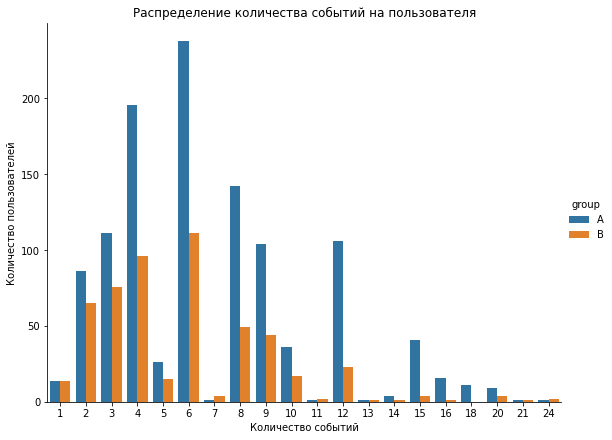

In [38]:
events_cnt = (
    ab_events
    .groupby('user_id', as_index=False)
    .agg({'event_name': 'count', 'group': 'min'})
    .rename(columns={'event_name':'events_count'})
)
data = (
    events_cnt
    .groupby(['events_count', 'group'], as_index=False)
    .agg({'user_id':'count'})
    .sort_values('events_count')
)
sns.catplot(x='events_count', y='user_id', 
            hue='group', data=data, kind='bar', 
            height=6, aspect=8/6
           )
plt.title("Распределение количества событий на пользователя")
plt.xlabel("Количество событий")
plt.ylabel("Количество пользователей")

plt.show() 

Из этой совместной столбчатой диаграммы мы сразу замечаем явный перекос в количестве пользователей в пользу контрольной группы, который казался менее явным на этапе предварительной оценки. Возможно, нам еще предстоит выяснить причину такого перекоса. С поправкой же на разницу в количестве пользователей в целом количество событий распределено примерно одинаково в обеих группах: в обоих случаях мы фиксируем пиковые значения на отметках в 4 и 6 событий, довольно высокие показатели на отметках 8, 9, 12. Ощутимая разница заметна лишь в левой части графика: на отметках в 2-3 события высота оранжевых столбцов почти равна высоте синих, а на отметке 1 событие оранжевый столбец оказался даже выше синего. Все это говорит нам о том, что в группе В доля малоактивных пользователей оказалась больше, чем в группе А.

Теперь изучим вопрос, как число событий в выборках распределено по дням. Для этого сначала отсечем от точного времени события часы, минуты и секунды и оставим лишь информацию о дне:

In [39]:
ab_events['day'] = ab_events['event_dt'].dt.date

Теперь вновь построим парную столбчатую диаграмму:

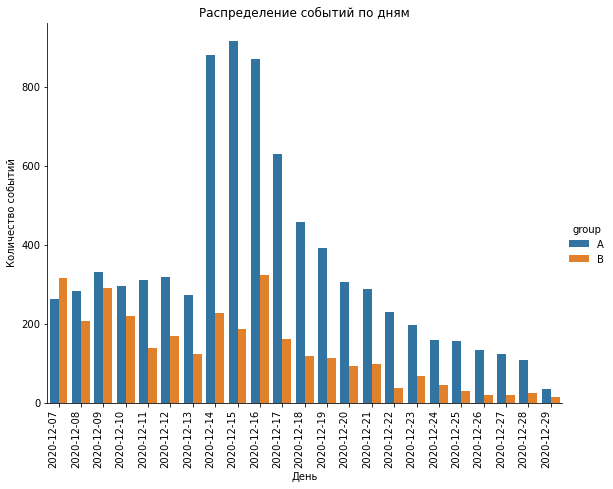

In [40]:
events_per_day = (ab_events
                  .groupby(['day', 'group'], as_index=False)
                  .agg({'event_name':'count'})
                  .rename(columns={'event_name': 'events_cnt'})
)

sns.catplot(x='day', y='events_cnt', 
            hue='group', data=events_per_day, kind='bar', 
            height=6, aspect=8/6
           )
plt.title("Распределение событий по дням")
plt.xlabel("День")
plt.ylabel("Количество событий")
plt.xticks(rotation=90, ha='right')

plt.show() 

Логично, что и на этом графике явно заметен перекос количества событий в пользу контрольной группы. Распределение событий в двух группах немного отличается: в группе А есть ярковыраженный пик, который приходится на 14-16 декабря. В группе В не один пик, а два: один приходится на 7-10 декабря, второй на те же дни 14-16 декабря, но они менее ярко выражены, чем пик в группе А. В обоих случаях мы видим постепенное снижение общей активности пользователей после 16 декабря.

Теперь построим воронку событий и изучим, как меняется конверсия в воронке в выборках на разных этапах. Для этого сначала добавим в наш датасет с событиями информацию об еще одном событии: регистрации пользователей, которая станет первым этапом нашей воронки:

In [41]:
ab_new_users['event_name'] = 'registration'
ab_new_users = ab_new_users.merge(
    ab_participants[['user_id', 'group']], how='inner', on='user_id'
)
ab_new_users = ab_new_users.rename(columns={'first_date': 'event_dt'})

ab_events_withreg = pd.concat(
    [ab_events, ab_new_users[['user_id', 'event_dt', 'event_name', 'group']]]
)
ab_events_withreg['day'] = ab_events['event_dt'].dt.date

Затем для каждой группы составим сводную таблицу, необходимую для построения воронки:

In [42]:
funnel_data = (
    ab_events_withreg
    .groupby(['user_id', 'event_name'], as_index=False)
    .agg({'event_dt':'nunique', 'group': 'min'})
)

funnel_a = (funnel_data
          .query('group == "A"')
          .groupby('event_name', as_index=False)
          .agg({'user_id':'count'})
          .sort_values('user_id', ascending=False)
)

funnel_b = (funnel_data
          .query('group == "B"')
          .groupby('event_name', as_index=False)
          .agg({'user_id':'count'})
          .sort_values('user_id', ascending=False)
)

Строим графики воронки. Для группы А:

In [43]:
#fig = go.Figure(go.Funnel(
    #y = funnel_a['event_name'],
    #x = funnel_a['user_id'],
    #textposition='inside',
    #textinfo = "value+percent initial"))
#fig.update_layout({'title': 'Воронка событий для группы А' })

#fig.show()

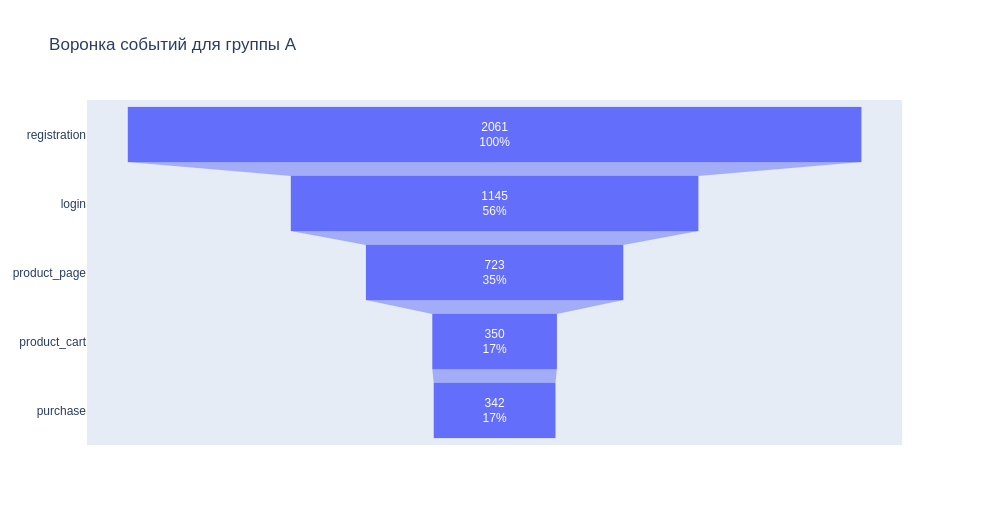

Для группы В:

In [44]:
#fig = go.Figure(go.Funnel(
    #y = funnel_b['event_name'],
    #x = funnel_b['user_id'],
    #textposition='inside',
    #textinfo = "value+percent initial"))
#fig.update_layout({'title': 'Воронка событий для группы В' })

#fig.show()

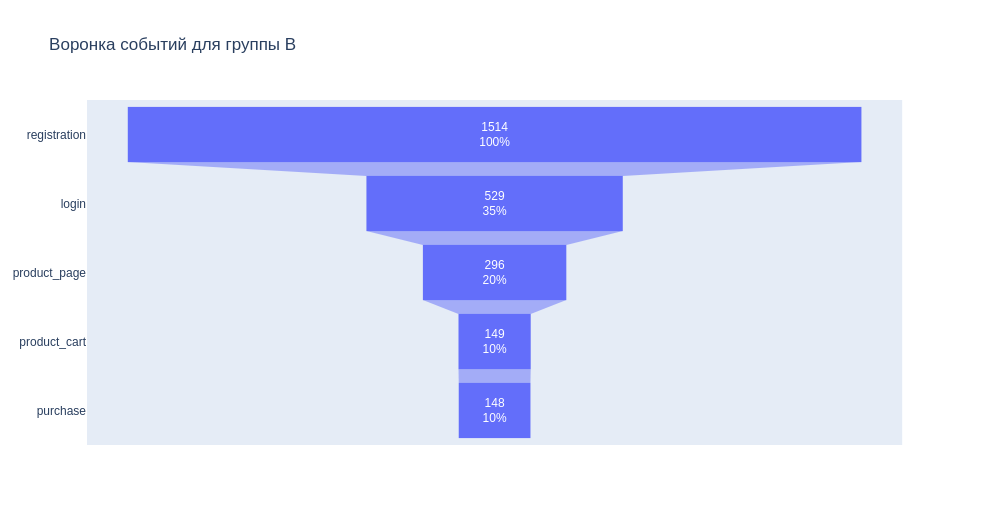

Построение воронки выявило еще одну проблему в проведении А/В-тестирования. Данный тест проверял новую систему рекомендаций, направленную на улучшение конверсии на последующих после логина этапах. Соответственно, у нас в обеих группах должна наблюдаться приблизительно одинаковая конверсия зарегистрированных пользователей в логины. Но она очень сильно различается, и в результате это и привело к такой большей разнице в количестве пользователей между группами А и В на столбчатых диаграммах выше. Такая большая разница в конверсии там, где ее не должно быть, вновь говорит нам о некорректности проведенного А/B-теста. Мы обращали ранее внимание, что после фильтрации аудитории мы анализируем слишком маленькие выборки, а небольшая относительно ожидаемого ТЗ выборка может исказить результаты исследования: не успеет сработать закон больших чисел; ведь если наблюдений мало, их разброс больше. В данном случае этот разброс значений сказался именно на этапе конверсии зарегистрированных пользователей в логины. 

Низкая конверсия группы В (или наоборот, слишком высокая конверсия группы А) усилила разницу в неравномерном распределении пользователей по группам: до этапа логина дошло 1145 пользователей из группы А и лишь 529 пользователей из группы В. В результате, как мы уже и сказали, мы наблюдали на столбчатых диаграммах сильный перекос количества пользователей и событий в сторону контрольной группы.

Поскольку наличие этапа регистрации на графике воронки сильно искажает результаты для группы В, ведь нам все-таки важнее сравнить конверсии последующих этапов, построим новые графики без этапа регистрации. Создаем новые сводные таблицы:

In [45]:
funnel_data = (
    ab_events
    .groupby(['user_id', 'event_name'], as_index=False)
    .agg({'event_dt':'nunique', 'group': 'min'})
)

funnel_a = (funnel_data
          .query('group == "A"')
          .groupby('event_name', as_index=False)
          .agg({'user_id':'count'})
          .sort_values('user_id', ascending=False)
).reset_index(drop=True)

funnel_b = (funnel_data
          .query('group == "B"')
          .groupby('event_name', as_index=False)
          .agg({'user_id':'count'})
          .sort_values('user_id', ascending=False)
).reset_index(drop=True)

Строим график воронки для группы А:

In [46]:
#fig = go.Figure(go.Funnel(
    #y = funnel_a['event_name'],
    #x = funnel_a['user_id'],
    #textposition='inside',
    #textinfo = "value+percent initial"))
#fig.update_layout({'title': 'Воронка событий для группы А' })

#fig.show()

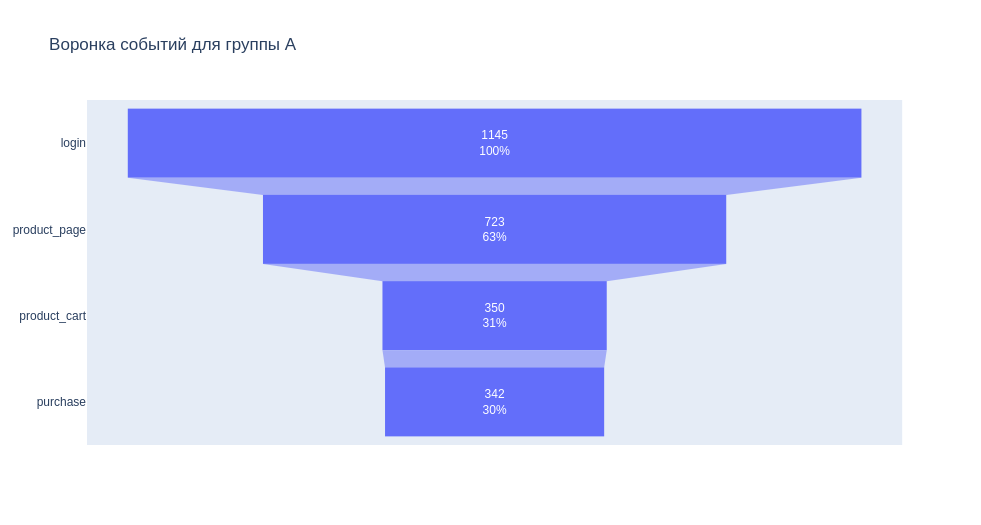

И для группы В:

In [47]:
#fig = go.Figure(go.Funnel(
    #y = funnel_b['event_name'],
    #x = funnel_b['user_id'],
    #textposition='inside',
    #textinfo = "value+percent initial"))
#fig.update_layout({'title': 'Воронка событий для группы В' })

#fig.show()

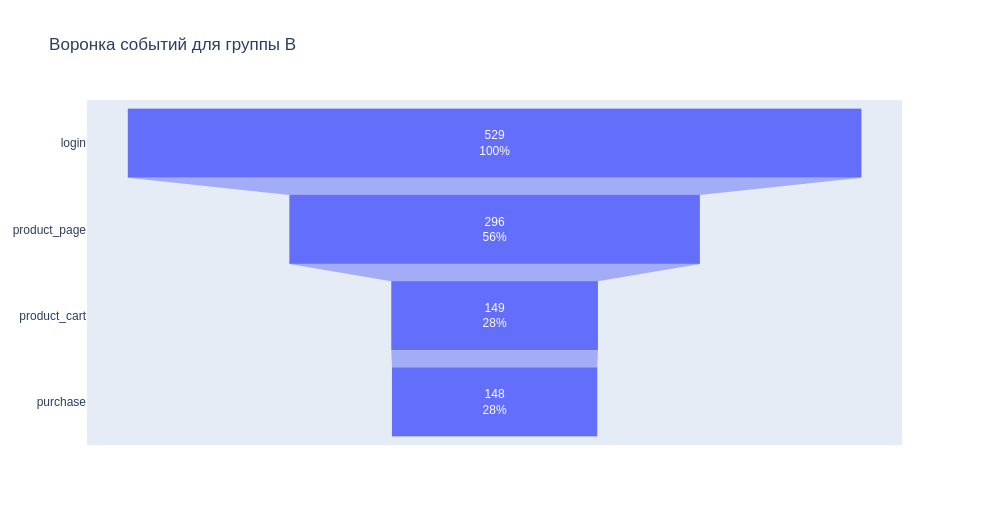

Мы видим, что при ожидаемом по ТЗ улучшении конверсии на каждом этапе не менее, чем на 10%, на самом деле, конверсия от общего числа пользователей в группе В на каждом этапе оказалась ниже, чем в группе А.

### Вывод

Исследовательский анализ данных выявил явный перекос в количестве пользователей в пользу контрольной группы, который казался менее явным на этапе предварительной оценки. Оказалось, что в двух группах сильно различается конверсия зарегистрированных пользователей в логины, хотя данный тест проверял новую систему рекомендаций, направленную на улучшение конверсии на последующих после логина этапах (следовательно, конверсия зарегистрированных пользователей в логины должна была быть примерно одинаковой в обеих выборках). Низкая конверсия группы В (или наоборот, слишком высокая конверсия группы А) усилила разницу в неравномерном распределении пользователей по группам: до этапа логина дошло 1145 пользователей из группы А и лишь 529 пользователей из группы В.

Такая большая разница в конверсии там, где ее не должно быть, вновь говорит нам о некорректности проведенного А/B-теста. Мы обращали ранее внимание, что после фильтрации аудитории мы анализируем слишком маленькие выборки, а небольшая относительно ожидаемого ТЗ выборка может исказить результаты исследования: не успеет сработать закон больших чисел; ведь если наблюдений мало, их разброс больше. В данном случае этот разброс значений сказался именно на этапе конверсии зарегистрированных пользователей в логины. 

Кроме того, построенный график воронки продемонстрировал нам несостоятельность тестируемой гипотезы: при ожидаемом по ТЗ улучшении конверсии на каждом этапе не менее, чем на 10%, на самом деле, конверсия от общего числа пользователей в группе В на каждом этапе оказалась ниже, чем в группе А.

## Оценка результатов A/B-тестирования

Уже на данном этапе можно заранее сказать, что проверяемая гипотеза себя не оправдала: по построенным графикам воронок мы увидели, что новая система рекомендаций не просто не дала прирост конверсии в 10% на каждом из этапов, а наоборот, конверсия от общего числа пользователей в группе В на каждом этапе оказалась ниже, чем в группе А. Но мы все равно проведем проверку на наличие статистической разницы в конверсиях на каждом этапе z-критерием. Напишем функцию для проверки гипотезы о равенстве долей:

In [48]:
def z_test(
    trials_1, successes_1, trials_2, successes_2, alpha
):  
    # пропорция успехов в первой группе:
    p1 = successes_1 / trials_1
    # пропорция успехов во второй группе:
    p2 = successes_2 / trials_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Для проведения z-теста будем пользоваться данными из составленных раннее сводных таблицы. Сводная таблица для группы А: 

In [49]:
funnel_a

,event_name,user_id
0,login,1145
1,product_page,723
2,product_cart,350
3,purchase,342


И для группы В:

In [50]:
funnel_b

,event_name,user_id
0,login,529
1,product_page,296
2,product_cart,149
3,purchase,148


Запускаем проверку на наличие статистической разницы в конверсиях на каждом этапе. Мы проводим три теста, поэтому применяем поправку Бонферрони к уровню значимости:

In [51]:
for stage in funnel_a['event_name'][1:]:
    print('Сравниваем доли конверсий залогиненных пользователей в', stage)
    print('Нулевая гипотеза: в обеих группах наблюдается одинаковая конверсия')
    print('Альтернативная гипотеза: конверсия отличается')
    ind = list(funnel_a['event_name']).index(stage)
    z_test(
        trials_1 = funnel_a.loc[0, 'user_id'],
        successes_1 = funnel_a.loc[ind, 'user_id'],
        trials_2 = funnel_b.loc[0, 'user_id'],
        successes_2 = funnel_b.loc[ind, 'user_id'],
        alpha = 0.5 / len(stage)
    )
    print()

Сравниваем доли конверсий залогиненных пользователей в product_page
Нулевая гипотеза: в обеих группах наблюдается одинаковая конверсия
Альтернативная гипотеза: конверсия отличается
p-значение:  0.005075690194317861
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравниваем доли конверсий залогиненных пользователей в product_cart
Нулевая гипотеза: в обеих группах наблюдается одинаковая конверсия
Альтернативная гипотеза: конверсия отличается
p-значение:  0.31798838290423626
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравниваем доли конверсий залогиненных пользователей в purchase
Нулевая гипотеза: в обеих группах наблюдается одинаковая конверсия
Альтернативная гипотеза: конверсия отличается
p-значение:  0.4290443292753203
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистическая разница наблюдается только на этапе конверсии залогиненных пользователей в просмотр карточек товаров, и она в пользу группы А (63% против 56%). По имеющимся у нас данным мы не можем сказать, что проверяемая гипотеза себя оправдала; контрольная группа показала лучшие результаты конверсии.

## Общий вывод

Проведенный А/В-тест имеет много уязвимостей, которые позволяют нам говорить, что он был проведен некорректно. 

Время проведения анализируемого нами A/B-теста (7 декабря — 4 января) совпадает с:
- праздничным периодом Рождества и Нового года в европейском регионе;
- проводимыми в честь этих праздников маркетинговых акций.

Безусловно это не могло не повлиять на поведение клиентов. В первую очередь, праздники и маркетинговые акции обычно становятся причинами всплесков потребительской активности. Это означает, что гипотеза, подтвержденная в этот период, когда покупательская активность сильно меняется, может показать абсолютно другие результаты, например, весной, когда покупательское поведение будет другое. С другой стороны, факт пересечения проведения А/B-теста с праздниками и маркетинговыми акциями можно проигнорировать, аргументировав это тем, что этот фактор одновременно влиял на обе группы участников теста, поэтому мы все-таки могли продолжить начатый анализ, но постоянно учитывая факт пересечения.

Проверка полученных данных на соответствие ТЗ выявила, что в нашем распоряжении оказались данные об активности пользователей лишь с 7 по 30 декабря включительно. Поскольку при анализе А/В-теста нас интересовала активность пользователей в первые 14 дней после регистрации, то нам пришлось при последующем анализе учитывать только тех пользователей интернет-магазина, которые зарегистрировались в период между 7 и 16 декабря. Кроме того, оказалось, что 783 пользователя стали участниками сразу двух тестов. Это означает, что на их поведение в приложении влиял фактор другого тестирования, поэтому мы не могли учитывать их активность при дальнейшем анализе A/B-теста. 

После фильтрации аудитории теста мы были вынуждены сократить количество участников теста с 6701 до 3575 человек. Это стало проблемой при дальнейшем анализе проведенного теста, поскольку небольшая относительно ожидаемого ТЗ выборка исказила результаты исследования: исследовательский анализ данных выявил явный перекос в количестве пользователей в пользу контрольной группы, который казался менее явным на этапе предварительной оценки. Оказалось, что в двух группах сильно различается конверсия зарегистрированных пользователей в логины, хотя данный тест проверял новую систему рекомендаций, направленную на улучшение конверсии на последующих после логина этапах (следовательно, конверсия зарегистрированных пользователей в логины должна была быть примерно одинаковой в обеих выборках). Низкая конверсия группы В (или наоборот, слишком высокая конверсия группы А) усилила разницу в неравномерном распределении пользователей по группам: до этапа логина дошло 1145 пользователей из группы А и лишь 529 пользователей из группы В.

Такая большая разница в конверсии там, где ее не должно быть, вновь говорит нам о некорректности проведенного А/B-теста. Мы обращали ранее внимание, что после фильтрации аудитории мы анализируем слишком маленькие выборки, а небольшая относительно ожидаемого ТЗ выборка может исказить результаты исследования: не успеет сработать закон больших чисел; ведь если наблюдений мало, их разброс больше. В данном случае этот разброс значений сказался именно на этапе конверсии зарегистрированных пользователей в логины. 

Кроме того, построенный график воронки продемонстрировал нам несостоятельность тестируемой гипотезы: при ожидаемом по ТЗ улучшении конверсии на каждом этапе не менее, чем на 10%, на самом деле, конверсия от общего числа пользователей в группе В на каждом этапе оказалась ниже, чем в группе А.

Проверка на наличие статистической разницы в конверсиях на каждом этапе z-критерием показала, что статистическая разница наблюдается только на этапе конверсии залогиненных пользователей в просмотр карточек товаров, и она в пользу группы А (63% против 56%). По имеющимся у нас данным мы не можем сказать, что проверяемая гипотеза себя оправдала; контрольная группа показала лучшие результаты конверсии. *Но основная проблема заключается в том, что мы не можем однозначно быть уверены, что тестируемая гипотеза не работает, возможно, результаты исследования были искажены всеми теми недочетами, указанными выше.*